In [53]:
using MAT
using WebIO
using PyCall
using PyPlot
using Eirene
using Random
using Statistics

rng = MersenneTwister(1337);

#### TODO (WZ):
- For each simulation condition (clustered, spanning and individual) at steady state (time-step 150,000) compute changes in Wasserstein distance after randomly removing points (similar to code below). Consider separately Wasserstein distance for $H_0$ and $H_0 + H_1$. Each simulation (in `simulation-data` directory) consists of 200 cells. 

In [2]:
allvariables = matread("experimental-data/EGF(E6)w5.mat");
allx = allvariables["storeX"];
ally = allvariables["storeY"];
allxvel = allvariables["storevelX"];
allyvel = allvariables["storevelY"];

In [3]:
pos_x_final = allx[1:end,end];
pos_y_final = ally[1:end,end];
pos_x_final = filter!(!(isnan), pos_x_final);
pos_y_final = filter!(!(isnan), pos_y_final);
pos_final = hcat(pos_x_final, pos_y_final)
pos_final = transpose(pos_final)

2×451 LinearAlgebra.Transpose{Float64,Array{Float64,2}}:
 123.6  561.6  504.4  516.1  585.5  …  804.5  199.1  267.4  872.5  434.9
 130.5  189.6  270.0  398.3  353.6     584.5  645.3  686.8  548.3  469.8

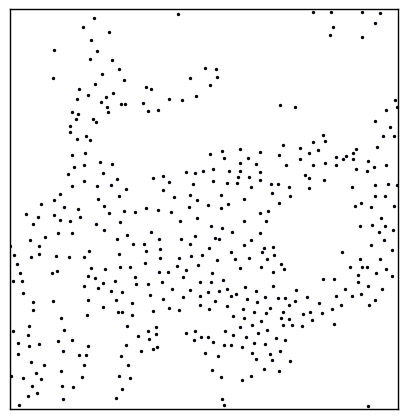

In [14]:
figure(figsize=(5,5))
scatter(pos_x_final, pos_y_final, s=2);
xlim([0, 900])
ylim([0, 900])
xticks([]);
yticks([]);

In [15]:
persist_diag = eirene(pos_final, model="pc", maxdim=1)

Dict{String,Any} with 12 entries:
  "symmat"   => [84585 83786 … 0 0; 83786 84585 … 0 0; … ; 0 0 … 84585 83586; 0…
  "maxnz"    => [0, 18893, 2345342, 1, 0]
  "firstv"   => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  443, 444, 445…
  "cyclerep" => Array{Array{Int64,1},1}[[], [[2, 3], [9, 6], [1, 7], [2, 8], [2…
  "phi"      => Array{Int64,1}[[], [448, 2224, 6, 453, 450, 3985, 3, 900, 6152,…
  "plo"      => Array{Int64,1}[[], [3, 6, 7, 8, 5, 14, 4, 11, 21, 44  …  243, 1…
  "ocg2rad"  => [618.04, 618.027, 618.026, 618.02, 618.011, 618.001, 617.967, 6…
  "farfaces" => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  442, 443, 444…
  "nvl2ovl"  => [393, 107, 190, 39, 293, 378, 394, 29, 390, 222  …  223, 207, 2…
  "input"    => Dict{String,Any}("genera"=>[123.6 561.6 … 872.5 434.9; 130.5 18…
  "tid"      => Array{Int64,1}[[], [3, 6, 7, 8, 5, 14, 4, 11, 21, 44  …  110, 9…
  "grain"    => Array{Int64,1}[[84585, 84585, 84585, 84585, 84585, 84585, 84585…

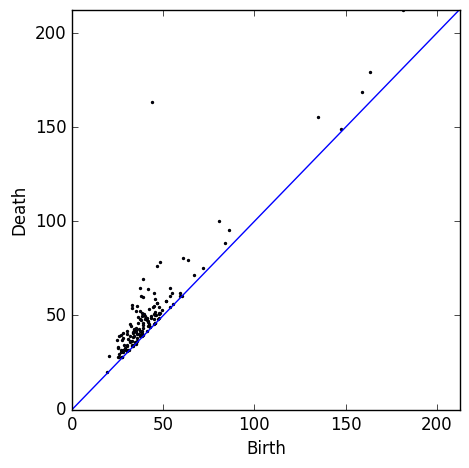

PyObject <matplotlib.text.Text object at 0x7fe7adbc0c88>

In [27]:
barcode_data = barcode(persist_diag)

# normalize by maximum coordinate value
barcode_coord_vals = sort(unique(collect(Iterators.flatten(barcode_data))))
max_coord = maximum(barcode_coord_vals)

# if max value is Inf, normalize by second largest values
if max_coord == Inf
    max_coord = barcode_coord_vals[end-1]
end

@assert max_coord != Inf

# replace Inf values
replace!(barcode_data, Inf=>max_coord)

# plot rescaled data
figure(figsize=(5,5))
scatter(barcode_data[:,1], barcode_data[:,2], s=2)
plot([0.1, max_coord], [0.1, max_coord], "b-")
xlim([0, max_coord])
ylim([0, max_coord])
xlabel("Birth")
ylabel("Death")

In [50]:
@time begin
    
    num_removals = 100
    num_reps = 3
    num_particles = size(pos_final)[2]

    wasserstein_distances = Array{Float64}(undef, num_removals, num_reps);

    for i in 1:num_removals
        for j in 1:num_reps
            permutation = randperm(rng, num_particles)
            keep_idx = permutation[1:(num_particles-i)]
            pos_tmp = pos_final[:, keep_idx]
            pers_diag_tmp = eirene(pos_tmp, model="pc", maxdim=1)
            barcode_tmp = barcode(pers_diag_tmp)
            wasserstein_distances[i, j] = wasserstein_distance(barcode_tmp, barcode_data, q=2, p=2)
        end
    end
    
end

442.813562 seconds (1.51 G allocations: 287.609 GiB, 16.60% gc time)


In [61]:
mean_ws_dist = mean(wasserstein_distances, dims=2);
std_ws_dist = std(wasserstein_distances, dims=2);

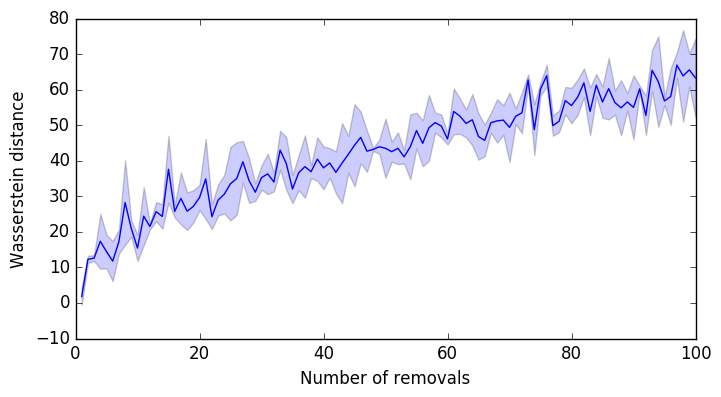

PyObject <matplotlib.text.Text object at 0x7fe7a2f35780>

In [89]:
xs = convert(Array, 1:num_removals)
lb = collect(Iterators.flatten(convert(Array, mean_ws_dist-std_ws_dist)))
ub = collect(Iterators.flatten(convert(Array, mean_ws_dist+std_ws_dist)))

figure(figsize=(8,4))
plot(1:num_removals, mean_ws_dist)
ax = gca()
fill_between(xs, lb, ub, alpha=0.2)
xlabel("Number of removals")
ylabel("Wasserstein distance")